In [158]:
using Gadfly

In [31]:
struct Fun{T}
    coeffs::Vector{T}
end
function Base.:+(f::Fun{T}, g::Fun{T}) where {T}
    Fun{T}(f.coeffs + g.coeffs)
end
function Base.:-(f::Fun{T}, g::Fun{T}) where {T}
    Fun{T}(f.coeffs - g.coeffs)
end
function Base.:*(a::T, f::Fun{T}) where {T}
    Fun{T}(a * f.coeffs)
end

In [32]:
function sample(f, N)
    h = 1 / (N-1)
    coeffs = Float64[f(h*i) for i in 0:N-1]
    Fun{Float64}(coeffs)
end

sample (generic function with 1 method)

In [33]:
"""
Basis function hat(i, N, x)
"""
function hat(i, N, x::T) where {T}
    @assert 0 <= i < N
    # calculate grid spacing
    h = 1 / T(N-1)
    # collocation points
    xim1 = h * (i-1)
    xi = h * i
    xip1 = h * (i+1)
    # case distinction (piecewise linear!)
    if x <= xim1
        return T(0)
    elseif x <= xi
        return (x - xim1) / h
    elseif x <= xip1
        return -(x - xip1) / h
    else
        return T(0)
    end
end

hat

In [34]:
function evaluate(f::Fun{T}, x) where {T}
    N = length(f.coeffs)
    sum(f.coeffs[i+1] * hat(i, N, x) for i in 0:N-1)
end

evaluate (generic function with 1 method)

In [298]:
function quad(f::Fun{T}) where {T}
    N = length(f.coeffs)
    h = 1 / T(N-1)
    # initialize sum to zero
    s = T(0)
    for i in 0:N-1
        # boundary basis functions have half the area
        if i==0 || i==N-1
            w = T(0.5)
        else
            w = T(1)
        end
        # add up contributions from all basis functions
        s += w * h * f.coeffs[i+1]
    end
    s
end

quad (generic function with 1 method)

In [299]:
function l2norm(f::Fun{T}) where {T}
    coeffs_abs2 = [abs(c)^2 for c in f.coeffs]
    sqrt(quad(Fun{T}(coeffs_abs2)))
end

l2norm (generic function with 1 method)

In [300]:
function deriv(f::Fun{T})::Fun{T} where {T}
        N = length(f.coeffs)
        h = 1/T(N-1)
        deriv_coeffs = similar(f.coeffs)
        for i in 1:N
            if i==1
                deriv_coeffs[i] = (f.coeffs[2] - f.coeffs[1]) / h
            elseif i == N
                deriv_coeffs[i] = (f.coeffs[N] - f.coeffs[N-1]) / h
            else
                deriv_coeffs[i] = (f.coeffs[i+1] - f.coeffs[i-1]) / (2h)
            end
        end
        Fun{T}(deriv_coeffs)
    end

deriv (generic function with 1 method)

In [35]:
function deriv2(f::Fun{T})::Fun{T} where {T}
        N = length(f.coeffs)
        h = 1/T(N-1)
        deriv2_coeffs = similar(f.coeffs)
        for i in 1:N
            if i==1
                deriv2_coeffs[i] =  (f.coeffs[3] - 2*f.coeffs[2] + f.coeffs[1]) / h^2
            elseif i == N
                deriv2_coeffs[i] =  (f.coeffs[N] - 2*f.coeffs[N-1] + f.coeffs[N-2]) / h^2
            else
                deriv2_coeffs[i] = (f.coeffs[i+1] - 2*f.coeffs[i] + f.coeffs[i-1]) / h^2
            end
        end
        Fun{T}(deriv2_coeffs)
    end

deriv2 (generic function with 1 method)

In [36]:
"""
    rk2step(f, y, h)

Take one RK2 step with:
    f: right hand side function (y -> y')
    y: state vector y(0)
    h: step size
Output: 
    approximation of y(h)
"""
function rk2step(f, y0, h)
    k0 = f(y0)
    y1 = y0 + h/2*k0
    k1 = f(y1)
    y2 = y0 + h*k1
    y2  
end

rk2step

In [37]:
"""
    rk2integrate(f, y0, h, n)

Integrate for n steps, return all results
"""

function rk2integrate(f, y0, h, n)
    res = [y0]
    for i in 1:n
        y1 = rk2step(f,y0,h)
        push!(res,y1)
        y0 = y1
    end
    res
end

rk2integrate (generic function with 1 method)

In [60]:
function wave(state)
    psi, psidot = state
    psidotdot = deriv2(psi) 
    psidot.coeffs[1] = 0
    psidot.coeffs[end] = 0
    [psidot, psidotdot]
end

wave (generic function with 1 method)

In [297]:
function waveEnergy(psidot,psiprime)
    energy = 1/2 * (l2norm(psidot)^2 + l2norm(psiprime)^2)
    energy
end

waveEnergy (generic function with 1 method)

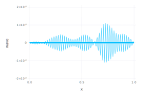

In [326]:
xs = [i/1000 for i in 0:1000]
nHats = 100
T = 1
delta_t = 10^-2
nPlots=10

g(x) = sin(pi*x)
f(x) = 0
g11coeffs = sample(g, nHats)
f11coeffs = sample(f, nHats)

results = rk2integrate(wave, [g11coeffs, f11coeffs], delta_t, T/delta_t);

psi_t = Any[]
energy_t = Any[]
time_t = Any[]

psi, psidot = results[1]
push!(psi_t,layer(x=xs, y=[evaluate(psi,x) for x in xs],Geom.line))
push!(time_t,0)
push!(energy_t,waveEnergy(psidot,deriv(psi)))

for i=1:nPlots
    psi, psidot = results[convert(Int,floor(i*T/delta_t/nPlots))]
    push!(psi_t,layer(x=xs, y=[evaluate(psi,x) for x in xs],Geom.line))
    push!(time_t,floor(i*T/nPlots))
    push!(energy_t,waveEnergy(psidot,deriv(psi)))
end 
plot(psi_t...,Guide.xlabel("x"),Guide.ylabel("wave"))

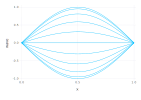

In [325]:
xs = [i/1000 for i in 0:1000]
nHats = 100
T = 1
delta_t = 10^-5
nPlots=10

g(x) = sin(pi*x)
f(x) = 0
g11coeffs = sample(g, nHats)
f11coeffs = sample(f, nHats)

results = rk2integrate(wave, [g11coeffs, f11coeffs], delta_t, T/delta_t);

psi_t = Any[]
energy_t = Any[]
time_t = Any[]

psi, psidot = results[1]
push!(psi_t,layer(x=xs, y=[evaluate(psi,x) for x in xs],Geom.line))
push!(time_t,0)
push!(energy_t,waveEnergy(psidot,deriv(psi)))

for i=1:nPlots
    psi, psidot = results[convert(Int,floor(i*T/delta_t/nPlots))]
    push!(psi_t,layer(x=xs, y=[evaluate(psi,x) for x in xs],Geom.line))
    push!(time_t,floor(i*T/nPlots))
    push!(energy_t,waveEnergy(psidot,deriv(psi)))
end 
plot(psi_t...,Guide.xlabel("x"),Guide.ylabel("wave"))

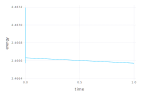

In [318]:
plot(x=time_t,y=energy_t,Geom.line,Guide.xlabel("time (s)"),Guide.ylabel("energy (J)"))